# 실력이 부족해 혼자할수가없어서 생성형ai 프롬포트를 통해 만들었습니다.

In [ ]:
# 1. 환경 설정 및 데이터 로드 (Environment Setup & Data Loading)
# 2. 데이터 탐색 (Exploratory Data Analysis, EDA)
# 3. 데이터 전처리 (Data Preprocessing) -- **중요!**
# 4. 피처 엔지니어링 (Feature Engineering)
# 5. 모델링 및 학습 (Modeling & Training)
# 6. 모델 평가 및 튜닝 (Evaluation & Tuning)
# 7. 7. 최종 예측 및 제출 (Prediction & Submission)

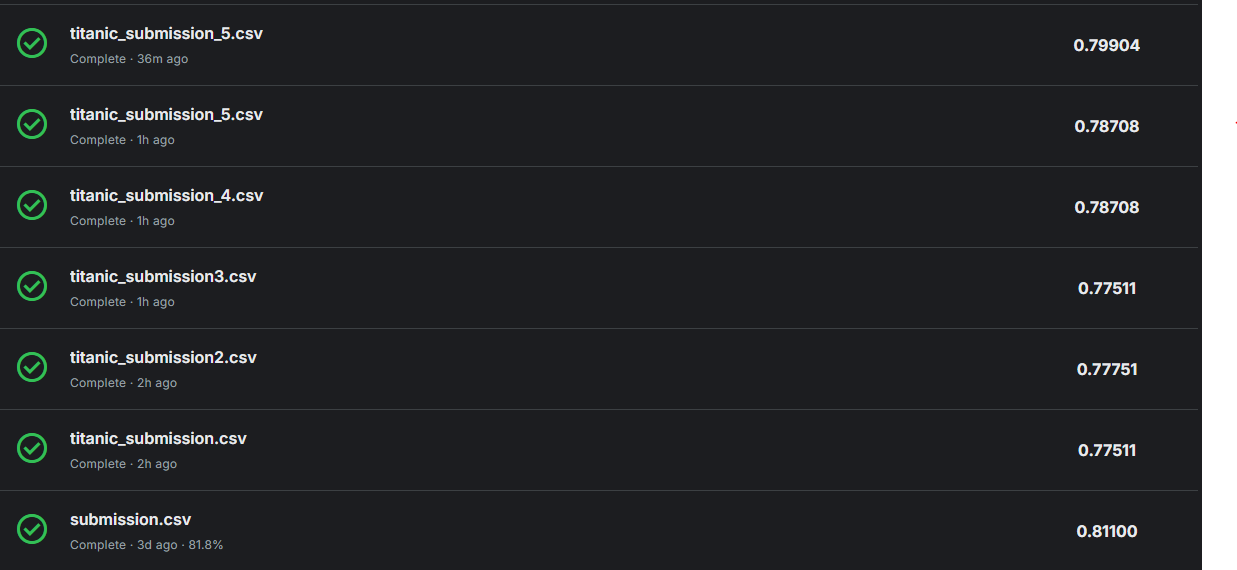

## **1. 환경 설정 및 데이터 로드 (Environment Setup & Data Loading)**

In [ ]:
from sklearn.model_selection import StratifiedKFold

# =========================
# 4. Feature Engineering
# =========================

# 1) 먼저 그룹/범주 피처 생성 (OOF보다 먼저!)
for df in (train2, test2):
    df["LastName"] = df["Name"].fillna("Unknown").astype(str).str.split(",").str[0].str.strip()
    df["HasCabin"] = df["Cabin"].notna().astype(int)

    tp = df["Ticket"].fillna("").astype(str)
    df["TicketPrefix"] = (
        tp.str.replace(r"\d+", "", regex=True)
          .str.replace(r"[./\s]+", "", regex=True)
          .str.strip()
          .replace("", "NONE")
    )

    df["FamilyID"] = df["LastName"] + "_" + df["FamilySize"].astype(int).astype(str)

# 2) OOF 그룹 생존률 피처 함수
def add_oof_group_survival_features(train_df, test_df, target_col, group_cols,
                                   n_splits=5, seed=42, smoothing=10):
    prior = train_df[target_col].mean()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for gcol in group_cols:
        oof_feat = np.zeros(len(train_df), dtype=float)

        for tr_idx, va_idx in skf.split(train_df, train_df[target_col]):
            tr = train_df.iloc[tr_idx]
            va = train_df.iloc[va_idx]

            stats = tr.groupby(gcol)[target_col].agg(["mean", "count"])
            smooth_mean = (stats["mean"] * stats["count"] + prior * smoothing) / (stats["count"] + smoothing)

            oof_feat[va_idx] = va[gcol].map(smooth_mean).fillna(prior).astype(float)

        feat_name = f"GS_{gcol}"
        train_df[feat_name] = oof_feat

        stats_all = train_df.groupby(gcol)[target_col].agg(["mean", "count"])
        smooth_mean_all = (stats_all["mean"] * stats_all["count"] + prior * smoothing) / (stats_all["count"] + smoothing)

        test_df[feat_name] = test_df[gcol].map(smooth_mean_all).fillna(prior).astype(float)

    return train_df, test_df

# 3) TicketID는 통계 생성용으로만 잠깐 생성
train2["TicketID"] = train2["Ticket"].fillna("Missing").astype(str)
test2["TicketID"]  = test2["Ticket"].fillna("Missing").astype(str)

train2, test2 = add_oof_group_survival_features(
    train2, test2,
    target_col="Survived",
    group_cols=["FamilyID", "LastName", "TicketID"],
    n_splits=5,
    seed=42,
    smoothing=10
)

# TicketID는 입력에 쓰지 않으니 제거
train2.drop(columns=["TicketID"], inplace=True)
test2.drop(columns=["TicketID"], inplace=True)

# 4) 이제 모델 입력용 X_train/X_test 만들기 (이게 핵심!)
TARGET = "Survived"
ID_COL = "PassengerId"
DROP_COLS = ["Name", "Ticket", "Cabin"]  # 원문 제거

X_train = train2.drop([TARGET] + DROP_COLS, axis=1)
y_train = train2[TARGET].astype(int)
X_test  = test2.drop(DROP_COLS, axis=1)

# 5) 범주/수치 컬럼 정의 (OOF 통계는 수치로 들어가야 함)
cat_cols = ["Sex", "Embarked", "Title", "CabinDeck", "LastName", "TicketPrefix", "FamilyID"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("✅ X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("✅ num:", num_cols)
print("✅ cat:", cat_cols)


## **2. 데이터 탐색 (Exploratory Data Analysis, EDA)**

In [ ]:
# 2. 데이터 탐색 (Exploratory Data Analysis, EDA) - 시각화 버전
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. 파이 차트 (생존자 비율)
train['Survived'].value_counts().plot.pie(
    explode=[0, 0.05], 
    autopct='%1.1f%%', 
    ax=ax[0], 
    shadow=True, 
    colors=['#FF9999', '#66B2FF']
)
ax[0].set_title('Survived (Ratio)')
ax[0].set_ylabel('')  # Y축 라벨 제거

# 2. 막대 그래프 (생존자 수)
sns.countplot(x='Survived', data=train, palette=['#FF9999', '#66B2FF'], ax=ax[1])
ax[1].set_title('Survived (Count)')

plt.show()

## **3. 데이터 전처리 (Data Preprocessing) — 중요**

In [ ]:
# ====== 3번 셀 ======
def _extract_title(name: str) -> str:
    # "Braund, Mr. Owen Harris" -> "Mr"
    if pd.isna(name):
        return "Unknown"
    if "," in name and "." in name:
        return name.split(",")[1].split(".")[0].strip()
    return "Unknown"

def _simplify_title(title: str) -> str:
    rare = {"Lady","Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"}
    if title in rare:
        return "Rare"
    if title in ["Mlle", "Ms"]:
        return "Miss"
    if title == "Mme":
        return "Mrs"
    return title

def preprocess_base(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Title
    df["Title"] = df["Name"].apply(_extract_title).apply(_simplify_title)

    # Family
    df["FamilySize"] = df["SibSp"].fillna(0) + df["Parch"].fillna(0) + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

    # Ticket group size
    df["TicketGroupSize"] = df.groupby("Ticket")["Ticket"].transform("count")

    # Cabin deck (첫 글자)
    df["CabinDeck"] = df["Cabin"].fillna("U").astype(str).str[0]

    # Embarked 결측
    if "Embarked" in df.columns:
        df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

    # Fare 결측 + log
    if "Fare" in df.columns:
        df["Fare"] = df["Fare"].fillna(df["Fare"].median())
        df["LogFare"] = np.log1p(df["Fare"])
        df["FarePerPerson"] = df["Fare"] / df["FamilySize"]

    return df

train2 = preprocess_base(train)
test2  = preprocess_base(test)

# Age: Title + Pclass + Sex 그룹 중앙값으로 채우기
age_median = train2.groupby(["Title","Pclass","Sex"])["Age"].median()

def fill_age(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    def _fill_row(row):
        if pd.isna(row["Age"]):
            key = (row["Title"], row["Pclass"], row["Sex"])
            v = age_median.get(key, np.nan)
            if pd.isna(v):
                return train2["Age"].median()
            return v
        return row["Age"]

    df["Age"] = df.apply(_fill_row, axis=1)
    df["AgeBin"] = pd.cut(df["Age"], bins=[0, 16, 32, 48, 64, 100], labels=False, include_lowest=True)
    return df

train2 = fill_age(train2)
test2  = fill_age(test2)

print("전처리 완료:", train2.shape, test2.shape)


## **4. 피처 엔지니어링 (Feature Engineering)**

In [ ]:
# ====== 4번 셀 ======
from sklearn.model_selection import StratifiedKFold

# =========================
# 4. Feature Engineering
# =========================

# 1) 먼저 그룹/범주 피처 생성 (OOF보다 먼저!)
for df in (train2, test2):
    df["LastName"] = df["Name"].fillna("Unknown").astype(str).str.split(",").str[0].str.strip()
    df["HasCabin"] = df["Cabin"].notna().astype(int)

    tp = df["Ticket"].fillna("").astype(str)
    df["TicketPrefix"] = (
        tp.str.replace(r"\d+", "", regex=True)
          .str.replace(r"[./\s]+", "", regex=True)
          .str.strip()
          .replace("", "NONE")
    )

    df["FamilyID"] = df["LastName"] + "_" + df["FamilySize"].astype(int).astype(str)

# 2) OOF 그룹 생존률 피처 함수
def add_oof_group_survival_features(train_df, test_df, target_col, group_cols,
                                   n_splits=5, seed=42, smoothing=10):
    prior = train_df[target_col].mean()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for gcol in group_cols:
        oof_feat = np.zeros(len(train_df), dtype=float)

        for tr_idx, va_idx in skf.split(train_df, train_df[target_col]):
            tr = train_df.iloc[tr_idx]
            va = train_df.iloc[va_idx]

            stats = tr.groupby(gcol)[target_col].agg(["mean", "count"])
            smooth_mean = (stats["mean"] * stats["count"] + prior * smoothing) / (stats["count"] + smoothing)

            oof_feat[va_idx] = va[gcol].map(smooth_mean).fillna(prior).astype(float)

        feat_name = f"GS_{gcol}"
        train_df[feat_name] = oof_feat

        stats_all = train_df.groupby(gcol)[target_col].agg(["mean", "count"])
        smooth_mean_all = (stats_all["mean"] * stats_all["count"] + prior * smoothing) / (stats_all["count"] + smoothing)

        test_df[feat_name] = test_df[gcol].map(smooth_mean_all).fillna(prior).astype(float)

    return train_df, test_df

# 3) TicketID는 통계 생성용으로만 잠깐 생성
train2["TicketID"] = train2["Ticket"].fillna("Missing").astype(str)
test2["TicketID"]  = test2["Ticket"].fillna("Missing").astype(str)

train2, test2 = add_oof_group_survival_features(
    train2, test2,
    target_col="Survived",
    group_cols=["FamilyID", "LastName", "TicketID"],
    n_splits=5,
    seed=42,
    smoothing=10
)

# TicketID는 입력에 쓰지 않으니 제거
train2.drop(columns=["TicketID"], inplace=True)
test2.drop(columns=["TicketID"], inplace=True)

# 4) 이제 모델 입력용 X_train/X_test 만들기 (이게 핵심!)
TARGET = "Survived"
ID_COL = "PassengerId"
DROP_COLS = ["Name", "Ticket", "Cabin"]  # 원문 제거

X_train = train2.drop([TARGET] + DROP_COLS, axis=1)
y_train = train2[TARGET].astype(int)
X_test  = test2.drop(DROP_COLS, axis=1)

# 5) 범주/수치 컬럼 정의 (OOF 통계는 수치로 들어가야 함)
cat_cols = ["Sex", "Embarked", "Title", "CabinDeck", "LastName", "TicketPrefix", "FamilyID"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("✅ X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("✅ num:", num_cols)
print("✅ cat:", cat_cols)


## **5. 모델링 및 학습 (Modeling & Training)**

In [ ]:
# ====== 5번 셀 ======
# ====== 5. Modeling & Training (Ensemble 준비) ======

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# --- CatBoost 준비 (이미 사용 중이면 그대로 OK) ---
from catboost import CatBoostClassifier

# CatBoost용 데이터(문자/결측 처리) - 이미 만들었다면 그대로 재사용해도 됨
X_train_cb = X_train.copy()
X_test_cb  = X_test.copy()

for c in num_cols:
    med = X_train_cb[c].median()
    X_train_cb[c] = X_train_cb[c].fillna(med)
    X_test_cb[c]  = X_test_cb[c].fillna(med)

for c in cat_cols:
    X_train_cb[c] = X_train_cb[c].fillna("Missing").astype(str)
    X_test_cb[c]  = X_test_cb[c].fillna("Missing").astype(str)

cat_features = cat_cols

cat_model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.02,
    depth=6,
    l2_leaf_reg=3.0,
    loss_function="Logloss",
    eval_metric="Accuracy",
    random_seed=42,
    verbose=0
)

# --- LightGBM 준비 ---
try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

if not HAS_LGBM:
    raise RuntimeError("LightGBM이 설치되어 있지 않습니다. Kaggle이면 보통 설치되어 있어야 합니다.")

# LGBM은 OneHot이 안정적
numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

lgbm_preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ]
)

lgbm_model = LGBMClassifier(
    n_estimators=3000,
    learning_rate=0.02,
    num_leaves=31,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.8,
    min_child_samples=20,
    random_state=42
)

lgbm_clf = Pipeline(steps=[
    ("preprocess", lgbm_preprocess),
    ("model", lgbm_model)
])

print("✅ Models ready: CatBoost + LightGBM")


## **6. 모델 평가 및 튜닝 (Evaluation & Tuning)**

In [ ]:
# ====== 6번 셀 ======
# ====== 6. Evaluation & Tuning (Ensemble OOF) ======

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_cat = np.zeros(len(X_train_cb), dtype=float)
oof_lgb = np.zeros(len(X_train_cb), dtype=float)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_cb, y_train), 1):
    X_tr_cb, X_va_cb = X_train_cb.iloc[tr_idx], X_train_cb.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    # --- CatBoost fold fit ---
    m_cat = CatBoostClassifier(**cat_model.get_params())
    m_cat.set_params(early_stopping_rounds=200)
    m_cat.fit(
        X_tr_cb, y_tr,
        cat_features=cat_features,
        eval_set=(X_va_cb, y_va),
        use_best_model=True
    )
    p_cat = m_cat.predict_proba(X_va_cb)[:, 1]
    oof_cat[va_idx] = p_cat

    # --- LGBM fold fit ---
    X_tr_lgb, X_va_lgb = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    lgbm_clf.fit(X_tr_lgb, y_tr)
    p_lgb = lgbm_clf.predict_proba(X_va_lgb)[:, 1]
    oof_lgb[va_idx] = p_lgb

    # quick fold report (기본 0.5로)
    p_ens05 = 0.6 * p_cat + 0.4 * p_lgb
    pred = (p_ens05 >= 0.5).astype(int)
    acc = accuracy_score(y_va, pred)
    print(f"[Fold {fold}] ENS(0.6/0.4, thr=0.5) ACC = {acc:.5f}")

# ---- 앙상블 가중치 + threshold 같이 튜닝 ----
best = {"w": 0.6, "thr": 0.5, "acc": 0.0}

for w in np.linspace(0.2, 0.9, 15):  # Cat 가중치
    p_ens = w * oof_cat + (1 - w) * oof_lgb
    for thr in np.linspace(0.35, 0.65, 61):
        pred = (p_ens >= thr).astype(int)
        acc = accuracy_score(y_train, pred)
        if acc > best["acc"]:
            best = {"w": float(w), "thr": float(thr), "acc": float(acc)}

print("Best OOF:", best)
best_w = best["w"]
best_thr = best["thr"]


## **7. 최종 예측 및 제출 (Prediction & Submission)**

In [ ]:
# ====== 7번 셀 ======
# ====== 7. Prediction & Submission (Ensemble) ======

# --- CatBoost full fit ---
final_cat = CatBoostClassifier(**cat_model.get_params())
final_cat.set_params(early_stopping_rounds=200)
final_cat.fit(
    X_train_cb, y_train,
    cat_features=cat_features,
    eval_set=(X_train_cb, y_train),
    use_best_model=True
)

test_cat = final_cat.predict_proba(X_test_cb)[:, 1]

# --- LGBM full fit ---
lgbm_clf.fit(X_train, y_train)
test_lgb = lgbm_clf.predict_proba(X_test)[:, 1]

# --- Ensemble ---
test_proba = best_w * test_cat + (1 - best_w) * test_lgb
test_pred = (test_proba >= best_thr).astype(int)

submission = pd.DataFrame({
    "PassengerId": test[ID_COL],
    "Survived": test_pred
})

print("submission shape:", submission.shape)
print(submission.head())

submission.to_csv("finally_titanic.csv", index=False)
print("Saved: finally_titanic.csv")
print("Using weight(Cat):", best_w, "thr:", best_thr)
